In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import gridspec
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, roc_auc_score, auc

import xgboost
from xgboost import XGBRegressor, XGBClassifier

### DATA
pbot  --->  sum(bottom photomultipliers) (1 feature)

ptop  --->  sum(top photomultipliers) (1 feature)


ppeakS1 --> variables of S1 peak (8 features)

ppeakS2 --> variables of S2 peak (8 features)

    the 8 features: pT0    -> absolute initial time of the pulse (we will construct pT0(peakS2) - pT=(peakS1) )
                    pA    -> total integrated area of the pulse
                    pH    -> pulse maximum amplitude
                    pHT   -> time at which the pulse has max amplitude (from pT0)
                    pL    -> time length of the pulse
                    pL90  -> time length with 90% area of the pulse (from 5-95% integrated area)
                    pRMSW -> pulse root mean square (RMS) width
                    pHTL  -> ratio between pHT and pL

In [4]:
# # where all the data is stored
filefolder = 'processed/'

# select the DM mass
mDM = 500

In [5]:
B_pbot = np.loadtxt(filefolder + 'ER/pbot.txt')
B_ptop = np.loadtxt(filefolder + 'ER/ptop.txt')
B_ppeakS1 = np.loadtxt(filefolder + 'ER/ppeakS1.txt')
B_ppeakS2 = np.loadtxt(filefolder + 'ER/ppeakS2.txt')

print('B_pbot.shape: ', B_pbot.shape)
print('B_ptop.shape: ', B_ptop.shape)
print('B_ppeakS1.shape :', B_ppeakS1.shape)
print('B_ppeakS2.shape: ', B_ppeakS2.shape)



S_pbot = np.loadtxt(filefolder + 'mDM' + str(mDM) + 'GeV/pbot.txt')
S_ptop = np.loadtxt(filefolder + 'mDM' + str(mDM) + 'GeV/ptop.txt')
S_ppeakS1 = np.loadtxt(filefolder + 'mDM' + str(mDM) + 'GeV/ppeakS1.txt')
S_ppeakS2 = np.loadtxt(filefolder + 'mDM' + str(mDM) + 'GeV/ppeakS2.txt')

print('S_pbot.shape: ', S_pbot.shape)
print('S_ptop.shape: ', S_ptop.shape)
print('S_ppeakS1.shape :', S_ppeakS1.shape)
print('S_ppeakS2.shape: ', S_ppeakS2.shape)

B_pbot.shape:  (35549,)
B_ptop.shape:  (35549,)
B_ppeakS1.shape : (35549, 8)
B_ppeakS2.shape:  (35549, 8)
S_pbot.shape:  (32015,)
S_ptop.shape:  (32015,)
S_ppeakS1.shape : (32015, 8)
S_ppeakS2.shape:  (32015, 8)


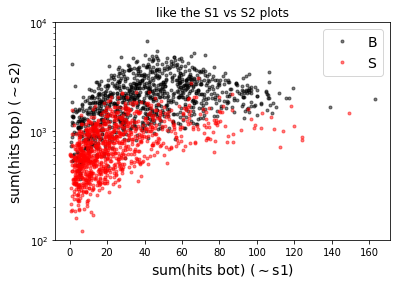

In [6]:
# plot to check

plt.plot(B_pbot[:1000], B_ptop[:1000], '.', color='black', alpha=0.5, label='B')
plt.plot(S_pbot[:1000], S_ptop[:1000], '.', color='red', alpha=0.5, label='S')
plt.yscale('log')
# plt.xlim([0,100])
plt.ylim([100,10000])
plt.xlabel(r'sum(hits bot) ($\sim$s1)',fontsize=14)
plt.ylabel(r'sum(hits top) ($\sim$s2)',fontsize=14)
plt.title('like the S1 vs S2 plots')
plt.legend(fontsize=14)
plt.show()

##### Select the number of events per class

In [7]:
# to have the same number of background and signal events
NUM_DAT = min(len(B_pbot), len(S_pbot))
print(' NUM_DAT: ', NUM_DAT, '\n')

B_pbot = B_pbot[:NUM_DAT]
B_ptop = B_ptop[:NUM_DAT]
B_ppeakS1 = B_ppeakS1[:NUM_DAT]
B_ppeakS2 = B_ppeakS2[:NUM_DAT]

print('B_pbot.shape: ', B_pbot.shape)
print('B_ptop.shape: ', B_ptop.shape)
print('B_ppeakS1.shape :', B_ppeakS1.shape)
print('B_ppeakS2.shape: ', B_ppeakS2.shape)


S_pbot = S_pbot[:NUM_DAT]
S_ptop = S_ptop[:NUM_DAT]
S_ppeakS1 = S_ppeakS1[:NUM_DAT]
S_ppeakS2 = S_ppeakS2[:NUM_DAT]

print('S_pbot.shape: ', S_pbot.shape)
print('S_ptop.shape: ', S_ptop.shape)
print('S_ppeakS1.shape :', S_ppeakS1.shape)
print('S_ppeakS2.shape: ', S_ppeakS2.shape)

 NUM_DAT:  32015 

B_pbot.shape:  (32015,)
B_ptop.shape:  (32015,)
B_ppeakS1.shape : (32015, 8)
B_ppeakS2.shape:  (32015, 8)
S_pbot.shape:  (32015,)
S_ptop.shape:  (32015,)
S_ppeakS1.shape : (32015, 8)
S_ppeakS2.shape:  (32015, 8)


###### Construct time diff between pulses

B_pdiffT.shape:  (32015,)
S_pdiffT.shape:  (32015,)


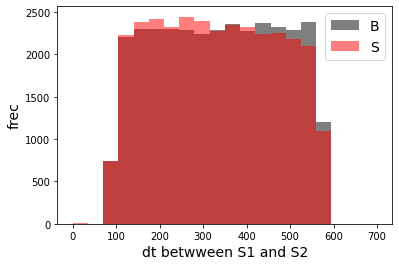

In [8]:
B_pdiffT = B_ppeakS2[:,0] - B_ppeakS1[:,0]
S_pdiffT = S_ppeakS2[:,0] - S_ppeakS1[:,0]

print('B_pdiffT.shape: ', B_pdiffT.shape)
print('S_pdiffT.shape: ', S_pdiffT.shape)


plt.hist(B_pdiffT, range=[0,700], bins=20, color='black', alpha=0.5, label='B')
plt.hist(S_pdiffT, range=[0,700], bins=20, color='red', alpha=0.5, label='S')
# plt.yscale('log')
# plt.xlim([0,100])
# plt.ylim([100,10000])
plt.xlabel('dt betwween S1 and S2',fontsize=14)
plt.ylabel('frec',fontsize=14)
plt.legend(fontsize=14)
plt.show()

##### Remove the absolute times of each pulse (we just need the time difference between pulses
other variables also can be removed if you want

In [9]:
remove_col = [0] # index = 0 is pT0

B_pbot = B_pbot
B_ptop = B_ptop
B_ppeakS1 = np.delete(B_ppeakS1, remove_col, axis=1)
B_ppeakS2 = np.delete(B_ppeakS2, remove_col, axis=1)

print('B_pbot.shape: ', B_pbot.shape)
print('B_ptop.shape: ', B_ptop.shape)
print('B_ppeakS1.shape :', B_ppeakS1.shape)
print('B_ppeakS2.shape: ', B_ppeakS2.shape)


S_pbot = S_pbot
S_ptop = S_ptop
S_ppeakS1 = np.delete(S_ppeakS1, remove_col, axis=1)
S_ppeakS2 = np.delete(S_ppeakS2, remove_col, axis=1)

print('S_pbot.shape: ', S_pbot.shape)
print('S_ptop.shape: ', S_ptop.shape)
print('S_ppeakS1.shape :', S_ppeakS1.shape)
print('S_ppeakS2.shape: ', S_ppeakS2.shape)

B_pbot.shape:  (32015,)
B_ptop.shape:  (32015,)
B_ppeakS1.shape : (32015, 7)
B_ppeakS2.shape:  (32015, 7)
S_pbot.shape:  (32015,)
S_ptop.shape:  (32015,)
S_ppeakS1.shape : (32015, 7)
S_ppeakS2.shape:  (32015, 7)


### Create the dataset to train the classifiers

In [10]:
# concatenate the data

# all the background features
X_mon_B = np.concatenate([B_ppeakS1, B_ppeakS2, np.reshape(B_pbot,(len(B_pbot),1)), np.reshape(B_ptop,(len(B_ptop),1)), np.reshape(B_pdiffT,(len(B_pdiffT),1)) ],axis=1)

# all the signal features
X_mon_S = np.concatenate([S_ppeakS1, S_ppeakS2, np.reshape(S_pbot,(len(S_pbot),1)), np.reshape(S_ptop,(len(S_ptop),1)), np.reshape(S_pdiffT,(len(S_pdiffT),1)) ],axis=1)

print('X_mon_B.shape: ', X_mon_B.shape)
print('X_mon_S.shape: ', X_mon_S.shape)
print('')

# del B_ppeakS1
# del B_ppeakS2
# del B_pbot
# del B_ptop

# del S_ppeakS1
# del S_ppeakS2
# del S_pbot
# del S_ptop

X_mon = np.concatenate([X_mon_B, X_mon_S])

print('X_mon.shape: ', X_mon.shape)
# del X_mon_B
# del X_mon_S


# labels
y_mon = np.concatenate([np.zeros(NUM_DAT),np.ones(NUM_DAT)])


# divide into train-val and test data samples
test_ratio = 0.25
val_ratio = 0.15


X_mon_aux, X_mon_test, y_mon_aux, y_mon_test = train_test_split(X_mon,
                                                                y_mon,
                                                                test_size=test_ratio,
                                                                random_state=42,
                                                                #stratify = y_mon,
                                                                shuffle=True)

del X_mon
del y_mon

X_mon_train, X_mon_val, y_mon_train, y_mon_val = train_test_split(X_mon_aux,
                                                                  y_mon_aux,
                                                                  test_size=val_ratio,
                                                                  random_state=42,
                                                                  #stratify = y_mon_aux,
                                                                  shuffle=True)

del X_mon_aux
del y_mon_aux

print('')
print('X_mon_train : ', X_mon_train.shape)
print('y_mon_train : ', y_mon_train.shape)
print('X_mon_val : ', X_mon_val.shape)
print('y_mon_val : ', y_mon_val.shape)
print('X_mon_test : ', X_mon_test.shape)
print('y_mon_test : ', y_mon_test.shape)
print('')

X_mon_B.shape:  (32015, 17)
X_mon_S.shape:  (32015, 17)

X_mon.shape:  (64030, 17)

X_mon_train :  (40818, 17)
y_mon_train :  (40818,)
X_mon_val :  (7204, 17)
y_mon_val :  (7204,)
X_mon_test :  (16008, 17)
y_mon_test :  (16008,)



## CLASSIFIERS

### XGBoost

[0]	validation_0-logloss:0.62914	validation_1-logloss:0.62988


/home/perez/anaconda3/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[1]	validation_0-logloss:0.57610	validation_1-logloss:0.57703
[2]	validation_0-logloss:0.53104	validation_1-logloss:0.53279
[3]	validation_0-logloss:0.49230	validation_1-logloss:0.49445
[4]	validation_0-logloss:0.45930	validation_1-logloss:0.46154
[5]	validation_0-logloss:0.43018	validation_1-logloss:0.43295
[6]	validation_0-logloss:0.40461	validation_1-logloss:0.40784
[7]	validation_0-logloss:0.38219	validation_1-logloss:0.38522
[8]	validation_0-logloss:0.36222	validation_1-logloss:0.36538
[9]	validation_0-logloss:0.34404	validation_1-logloss:0.34787
[10]	validation_0-logloss:0.32790	validation_1-logloss:0.33233
[11]	validation_0-logloss:0.31369	validation_1-logloss:0.31800
[12]	validation_0-logloss:0.30096	validation_1-logloss:0.30542
[13]	validation_0-logloss:0.28940	validation_1-logloss:0.29474
[14]	validation_0-logloss:0.27886	validation_1-logloss:0.28453
[15]	validation_0-logloss:0.26961	validation_1-logloss:0.27559
[16]	validation_0-logloss:0.26119	validation_1-logloss:0.26776
[

[131]	validation_0-logloss:0.13781	validation_1-logloss:0.17377
[132]	validation_0-logloss:0.13767	validation_1-logloss:0.17368
[133]	validation_0-logloss:0.13751	validation_1-logloss:0.17367
[134]	validation_0-logloss:0.13738	validation_1-logloss:0.17368
[135]	validation_0-logloss:0.13715	validation_1-logloss:0.17369
[136]	validation_0-logloss:0.13684	validation_1-logloss:0.17370
[137]	validation_0-logloss:0.13663	validation_1-logloss:0.17374
[138]	validation_0-logloss:0.13632	validation_1-logloss:0.17358
[139]	validation_0-logloss:0.13611	validation_1-logloss:0.17358
[140]	validation_0-logloss:0.13594	validation_1-logloss:0.17357
[141]	validation_0-logloss:0.13581	validation_1-logloss:0.17358
[142]	validation_0-logloss:0.13550	validation_1-logloss:0.17367
[143]	validation_0-logloss:0.13540	validation_1-logloss:0.17365
[144]	validation_0-logloss:0.13512	validation_1-logloss:0.17367
[145]	validation_0-logloss:0.13496	validation_1-logloss:0.17374
[146]	validation_0-logloss:0.13490	valid

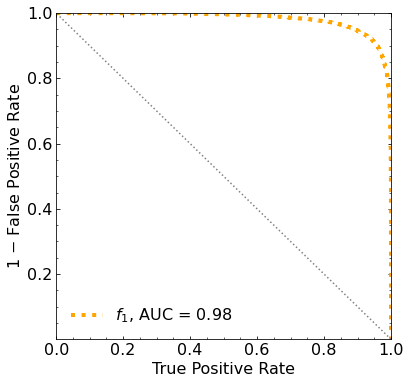

Classification score:


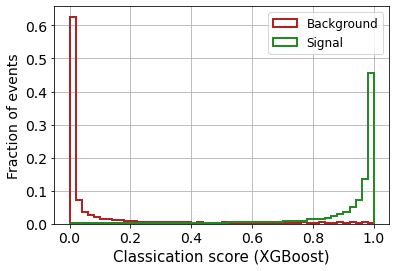


 ROC-AUC =  0.9810425521542311


In [28]:
# XGBoost with only the kinematic variables of the leptons

# CLASSIFIER
classifier = XGBClassifier(
    n_estimators=1500,
    learning_rate=0.1,
    reg_lambda=0.0,reg_alpha=0.0,
    gamma=0.0,objective='binary:logistic',
    max_depth=5,
    #eval_metric=["error", "logloss", "map"]
    eval_metric='logloss')

# FIT
classifier.fit(X_mon_train,y_mon_train,eval_set=[(X_mon_train, y_mon_train), (X_mon_val, y_mon_val)],
        early_stopping_rounds=50,#early stopping
        verbose=True)


# PREDICTIONS
y_pred_xg = classifier.predict_proba(X_mon_test).T[1]


# ROC
fpr_mon_xg, tpr_mon_xg, _ = roc_curve(y_mon_test, y_pred_xg)
roc_auc_xg = auc(fpr_mon_xg, tpr_mon_xg)


# PLOT THE ROC WITH AUC
fig = plt.figure(figsize=(6, 6))
gs = gridspec.GridSpec(1, 1) 
ax0 = plt.subplot(gs[0])
ax0.yaxis.set_ticks_position('both')
ax0.xaxis.set_ticks_position('both')
ax0.tick_params(direction="in",which="both")
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
ax0.minorticks_on()


plt.plot(tpr_mon_xg,1-fpr_mon_xg,label="$f_{1}$, AUC = %0.2f" % roc_auc_xg,color="orange",ls=":",lw=4)
plt.plot([1,0],[0,1],ls=":",color="grey")
plt.xlabel("True Positive Rate",fontsize=16)
plt.ylabel("1 $-$ False Positive Rate",fontsize=16)
plt.legend()
plt.xlim([0,1])
plt.ylim([0,1])
plt.yticks([0.2,0.4,0.6,0.8,1.])
plt.legend(frameon=False,fontsize=16)
plt.show()



# XGBoost with the kinematic variables of the leptons

########################
# CLASSIFICATION SCORE #
########################

# Outputs for validation data set

pred_XG_SM = []
pred_XG_NP = []

for i in range(len(y_mon_test)):
    if y_mon_test[i] == 0:
        pred_XG_SM.append(y_pred_xg[i])
    else:
        pred_XG_NP.append(y_pred_xg[i])
        
        
print('Classification score:')
        
weights = np.ones_like(pred_XG_SM)/float(len(pred_XG_SM))
nSM, binsSM, patchesSM = plt.hist(pred_XG_SM, 50, weights=weights, range=[0,1], histtype='step', color='firebrick', linewidth=2, label='Background')

weights = np.ones_like(pred_XG_NP)/float(len(pred_XG_NP))
nNP, binsNP, patchesNP = plt.hist(pred_XG_NP, 50, weights=weights, range=[0,1], histtype='step', color='forestgreen', linewidth=2, label='Signal')

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("Classication score (XGBoost)",fontsize=15)
plt.ylabel("Fraction of events",fontsize=14)
plt.grid()
plt.legend(fontsize=12)

plt.show()




print('\n ROC-AUC = ', roc_auc_xg)

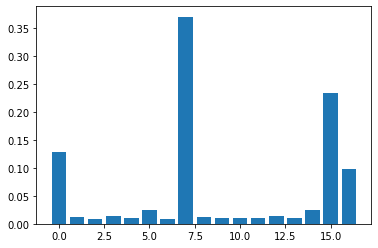

In [29]:
plt.bar(range(len(classifier.feature_importances_)), classifier.feature_importances_)
plt.show()

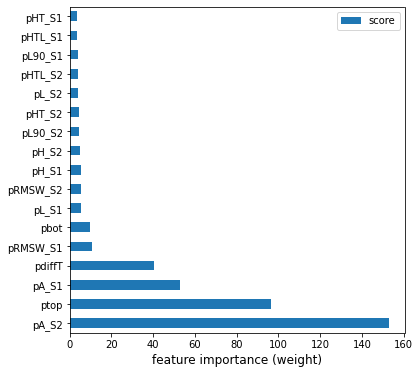

In [30]:
# IF YOU USED ALL THE FEATURES (but the absolute times)

feature_important = classifier.get_booster().get_score(importance_type='gain')
#keys = list(feature_important.keys())
keys = ['pA_S1','pH_S1','pHT_S1','pL_S1','pL90_S1','pRMSW_S1','pHTL_S1','pA_S2','pH_S2','pHT_S2','pL_S2','pL90_S2','pRMSW_S2','pHTL_S2','pbot', 'ptop','pdiffT']
values = list(feature_important.values())

data = pd.DataFrame(data=values, index=keys, columns=["score"]).sort_values(by = "score", ascending=False)
data.nlargest(40, columns="score").plot(kind='barh', figsize = (6,6)) ## plot top 40 features
plt.xlabel('feature importance (weight)', fontsize = 12)
plt.show()